# Computer Vision for Medical Imaging: Part 3. Deploy Model & Make Predictions
This notebook is part 3 of a 4-part series of techniques and services offer by SageMaker to build a model which predicts if an image of cells contains cancer. This notebook demonstrates how to use SageMaker to deploy a model and how to make predictions using the deployed model.

## Dataset
The dataset for this demo comes from the [Camelyon16 Challenge](https://camelyon16.grand-challenge.org/) made available under the CC0 licencse. The raw data provided by the challenge has been processed into 96x96 pixel tiles by [Bas Veeling](https://github.com/basveeling/pcam) and also made available under the CC0 license. For detailed information on each dataset please see the papers below:
* Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. [doi:jama.2017.14585](https://doi.org/10.1001/jama.2017.14585)
* B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". [arXiv:1806.03962](http://arxiv.org/abs/1806.03962)

The tiled dataset from Bas Veeling is over 6GB of data. In order to easily run this demo, the dataset has been pruned to the first 14,000 images of the tiled dataset and comes included in the repo with this notebook for convenience.

## Update Sagemaker SDK and Boto3

<div class="alert alert-warning">
<b>NOTE</b> You may get an error from pip's dependency resolver; you can ignore this error.
</div>

In [ ]:
%store -r
%store

## Import Libraries

In [ ]:
import boto3
import sagemaker
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import h5py
import cv2

## Configure Boto3 Clients and Sessions

In [ ]:
region = "us-west-2"  # Change region as needed
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()

## Create Model

In [ ]:
results = sagemaker.analytics.HyperparameterTuningJobAnalytics(tuning_job_name)
results_df = results.dataframe()
best_training_job_summary = results.description()["BestTrainingJob"]
best_training_job_details = sagemaker_boto_client.describe_training_job(
    TrainingJobName=best_training_job_name
)

In [ ]:
model_name = "metastasis-detection"
model_matches = sagemaker_boto_client.list_models(NameContains=model_name)["Models"]
training_image = sagemaker.image_uris.retrieve("image-classification", region)

if not model_matches:
    print(f"Creating model {model_name}")
    sagemaker_session.create_model_from_job(
        name=model_name,
        training_job_name=best_training_job_summary["TrainingJobName"],
        role=sagemaker_role,
        image_uri=training_image,
    )
else:
    print(f"Model {model_name} already exists.")

## Deploy Model

In [ ]:
training_jobs = results_df["TrainingJobName"]
best_model_index = np.where(training_jobs.values == best_training_job_summary["TrainingJobName"])[
    0
][0]
best_model_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=model_packages[best_model_index]["ModelPackageArn"]
)
best_model_container = best_model_info.get("InferenceSpecification").get("Containers")[0]
deploy_instance_type = best_model_info.get("InferenceSpecification").get(
    "SupportedRealtimeInferenceInstanceTypes"
)[0]

best_model = sagemaker.Model(
    image_uri=best_model_container.get("Image"),
    model_data=best_model_container.get("ModelDataUrl"),
    role=sagemaker.get_execution_role(),
    name=mpg_name,
)

best_model.deploy(
    initial_instance_count=1, instance_type=deploy_instance_type, endpoint_name=mpg_name
)

In [ ]:
%store deploy_instance_type

## Inference
Finally, the we can now validate the model for use. You can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.

In [ ]:
from sklearn.model_selection import train_test_split

with h5py.File("data/camelyon16_tiles.h5", "r") as hf:
    X = hf["x"][()]
    y = hf["y"][()]

X_numpy = X[:]
y_numpy = y[:]

X_train, X_test, y_train, y_test = train_test_split(
    X_numpy, y_numpy, test_size=1000, random_state=0
)

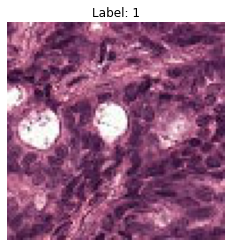

In [12]:
# view test image
image = X_test[0]
label = y_test[0]
plt.imshow(image)
plt.axis("off")
plt.title(f"Label: {label}");

In [13]:
from PIL import Image

img = Image.fromarray(X_test[0])
file_name = "data/test_image.jpg"
img.save(file_name)

In [14]:
import json

runtime = boto3.Session().client(service_name="runtime.sagemaker")
with open(file_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(
    EndpointName=mpg_name, ContentType="application/x-image", Body=payload
)

result = response["Body"].read()

# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)

[0.010918906889855862, 0.9890810251235962]


In [15]:
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
index

1

In [16]:
predictions = []
for i in range(len(X_test)):
    img = Image.fromarray(X_test[i])
    file_name = f"/tmp/test_image.jpg"
    img.save(file_name)

    with open(file_name, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime.invoke_endpoint(
        EndpointName=mpg_name, ContentType="application/x-image", Body=payload
    )

    result = response["Body"].read()
    result = json.loads(result)
    index = np.argmax(result)
    predictions.append(index)

In [17]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions)
print(f"Precision = {precision[1]}")
print(f"Recall = {recall[1]}")
print(f"F1-Score = {f1[1]}")

Precision = 0.8927835051546392
Recall = 0.8523622047244095
F1-Score = 0.8721047331319234


## Clean up resources

In [ ]:
best_model.sagemaker_session.delete_endpoint(mpg_name)